In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, ReLU, Dense, DepthwiseConv2D
from tensorflow.keras.models import Model

Class and Class ID :-
1. Asthma
2. Bronchiectasis
3. Bronchiolitis
4. Copd
5. Healthy
6. LRTI
7. Pneumonia
8. URTI

In [2]:
y_train=np.load('y_train.npy')
y_train.shape

(365,)

In [3]:
X_train=np.load('X_train.npy')
X_train.shape

(365, 192, 753, 3)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
print(X_train.shape,X_test.shape)

NameError: name 'X' is not defined

In [5]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
#X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_train = X_train/np.std(X_train)
#X_test = X_test/np.std(X_test)
y_train = np.array(y_train)
#y_test = np.array(y_test)

In [81]:
y_train.shape

(365,)

In [53]:
X_train

array([[[[3.29112715, 0.98394523, 1.98485503],
         [3.29112715, 0.98394523, 1.98485503],
         [2.52772137, 0.74644121, 1.93396132],
         ...,
         [2.57861509, 0.78037036, 1.84913845],
         [3.44380831, 1.05180352, 1.91699674],
         [3.44380831, 1.05180352, 1.91699674]],

        [[3.29112715, 0.98394523, 1.98485503],
         [3.29112715, 0.98394523, 1.98485503],
         [2.56165051, 0.74644121, 1.98485503],
         ...,
         [2.64647338, 0.78037036, 1.91699674],
         [3.44380831, 1.05180352, 1.91699674],
         [3.44380831, 1.05180352, 1.91699674]],

        [[3.30809172, 1.0009098 , 1.96789046],
         [3.30809172, 1.0009098 , 1.96789046],
         [2.57861509, 0.74644121, 1.98485503],
         ...,
         [2.66343795, 0.78037036, 1.93396132],
         [3.44380831, 1.05180352, 1.91699674],
         [3.44380831, 1.05180352, 1.91699674]],

        ...,

        [[4.29203695, 3.52863117, 2.49379222],
         [4.29203695, 3.52863117, 2.49379222]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=123)
print(X_train.shape,  X_val.shape, len(y_train),  len(y_val))

(219, 192, 753, 3) (146, 192, 753, 3) 219 146


<Font size = 6> <b> MobileNet Model </b></font>

In [32]:
def depth_block(x, strides):
    x = DepthwiseConv2D(3,strides=strides,padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
def single_conv_block(x,filters):
    x = Conv2D(filters, 1,use_bias=False)(x)
    x= BatchNormalization()(x)
    x = ReLU()(x)
    return x
def combo_layer(x,repetition, strides):
    x = depth_block(x,strides)
    filters=32
    x = single_conv_block(x, filters)
    return x
def MobileNet(input_shape=(192, 753, 3),n_classes = 4):
    input = Input (input_shape)
    x = Conv2D(32,3,strides=(2,2),padding = 'same', use_bias=False) (input)
    x =  BatchNormalization()(x)
    x = ReLU()(x)
    for i in range(1):
        x = combo_layer(x,64, strides=(1,1))
        x = combo_layer(x,128,strides=(2,2))
#         x = combo_layer(x,128,strides=(1,1))
#         x = combo_layer(x,256,strides=(2,2))
#         x = combo_layer(x,256,strides=(1,1))
#         x = combo_layer(x,512,strides=(2,2))
#     for _ in range(10):
#         x = combo_layer(x,512,strides=(1,1))
#     x = combo_layer(x,1024,strides=(2,2))
#     x = combo_layer(x,1024,strides=(1,1))
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes,activation='softmax')(x)
    model = Model(input, output)
    return model
n_classes = 4
input_shape = (192, 753, 3)
model = MobileNet(input_shape,n_classes)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 192, 753, 3)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 96, 377, 32)       864       
                                                                 
 batch_normalization_137 (Ba  (None, 96, 377, 32)      128       
 tchNormalization)                                               
                                                                 
 re_lu_137 (ReLU)            (None, 96, 377, 32)       0         
                                                                 
 depthwise_conv2d_67 (Depthw  (None, 96, 377, 32)      288       
 iseConv2D)                                                      
                                                                 
 batch_normalization_138 (Ba  (None, 96, 377, 32)      128 

In [33]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [34]:
md = model.fit(X_train, y_train, epochs=5, validation_data= (X_val, y_val))

Epoch 1/5
7/7 [==============================] - 24s 3s/step - loss: 1.3387 - accuracy: 0.3196 - val_loss: 1.3800 - val_accuracy: 0.3562
Epoch 2/5
7/7 [==============================] - 20s 3s/step - loss: 1.2327 - accuracy: 0.4201 - val_loss: 1.3691 - val_accuracy: 0.3562
Epoch 3/5
7/7 [==============================] - 20s 3s/step - loss: 1.1660 - accuracy: 0.4749 - val_loss: 1.3593 - val_accuracy: 0.3562
Epoch 4/5
7/7 [==============================] - 19s 3s/step - loss: 1.1427 - accuracy: 0.5205 - val_loss: 1.3520 - val_accuracy: 0.3562
Epoch 5/5
7/7 [==============================] - 19s 3s/step - loss: 1.1004 - accuracy: 0.5479 - val_loss: 1.3450 - val_accuracy: 0.3562


In [35]:
yt=model.predict(X_train, verbose=0)


In [36]:
yt.shape
for i in range(yt.shape[0]):
    print(str(y_train[i])+"  "+str(np.argmax(yt[i])))

2  1
0  1
0  1
1  1
0  1
2  1
1  1
2  1
3  1
1  1
0  1
0  1
0  1
2  1
1  1
0  1
0  1
0  1
1  1
1  1
0  1
1  1
1  1
0  1
2  1
1  1
0  1
0  1
1  1
0  1
0  1
0  1
0  1
1  1
3  1
2  1
0  1
3  1
1  1
1  1
1  1
3  1
1  1
0  1
1  1
1  1
0  1
0  1
1  1
1  1
1  1
0  1
0  1
2  1
1  1
1  1
0  1
1  1
0  1
2  1
0  1
0  1
0  1
1  1
0  1
1  1
2  1
1  1
1  1
3  1
0  1
0  1
0  1
2  1
1  1
1  1
3  1
3  1
1  1
1  1
0  1
1  1
2  1
3  1
1  1
0  1
1  1
1  1
0  1
1  1
2  1
3  1
0  1
2  1
0  1
2  1
1  1
3  1
3  1
2  1
3  1
0  1
1  1
3  1
1  1
0  1
2  1
0  1
1  1
1  1
1  1
0  1
0  1
0  1
1  1
1  1
1  1
1  1
3  1
0  1
1  1
1  1
1  1
2  1
3  1
2  1
3  1
0  1
1  1
1  1
0  1
1  1
1  1
1  1
2  1
1  1
1  1
1  1
2  1
3  1
1  1
2  1
2  1
3  1
0  1
1  1
0  1
1  1
0  1
1  1
1  1
1  1
1  1
0  1
1  1
1  1
1  1
1  1
1  1
3  1
1  1
0  1
1  1
0  1
3  1
1  1
2  1
0  1
1  1
0  1
1  1
2  1
1  1
0  1
1  1
0  1
0  1
1  1
2  1
3  1
1  1
0  1
1  1
3  1
3  1
1  1
1  1
1  1
3  1
1  1
2  1
0  1
1  1
0  1
0  1
1  1
1  1
2  1
0  1
2  1


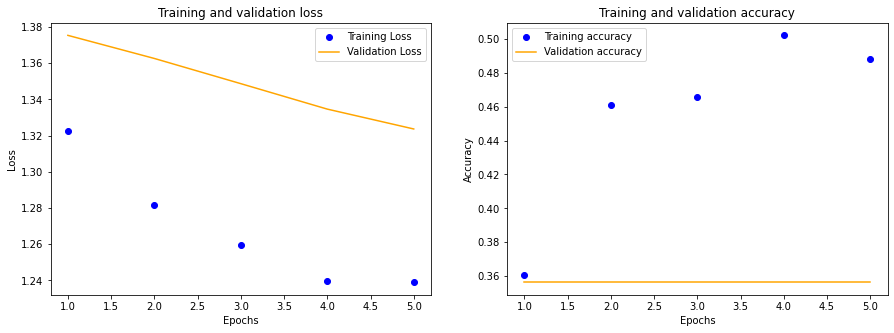

In [97]:
history=md
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,6)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()